# Kepler model

## Settings

In [1]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os
import matplotlib.pyplot as plt

from models import *
from hamiltonians import kepler
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic

DTYPE=tf.float32
NP_DTYPE=np.float32


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
sess = tf.InteractiveSession()

In [3]:
tf.set_random_seed(0)

In [4]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [5]:
k = -1
settings = {
    'k': k,
    'hamiltonian': lambda x : kepler(x,k=k),
    'd': 3,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**10,    # Mini batch size
    'dataset_size': 2**10, # Set to float("inf") for keeping sampling.
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/kepler",
    'visualize': True,
    #
    'train_iters': 100000,
    'starter_learning_rate': 1e-3, # for exp decay and none
    'decay_lr': "piecewise",
#     'decay_steps': 15000,  # for exp decay
#     'decay_rate': 0.5,     # for exp decay
    'boundaries': [10000, 30000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5],  # for piecewise decay
    'min_learning_rate': 1e-5, 
    #
    'loss': "dKdphi",
#    'base_dist': "action_exponential_angle",
    'base_dist': "action_dirac_angle"
#    'diff_val': -.5, 
#    'lambda_diff': 1.   # coeff |K-val|^2
#     ,
#     'elastic_net_coeff': 0., 
#     'low_K_range': -100, # A large value means all above this are OK
#     'high_K_range': -.01, 
#     'lambda_range': 10000.    # coeff range penalty
    }
# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
r = np.random.RandomState(seed=0)
num_samples_actions = 1 # number of distinct actions (Liouville torii)
sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
settings['value_actions'] = r.rand(*sh).astype(NP_DTYPE)
print(settings['value_actions'])

[[[[0.5488135 ]]

  [[0.71518934]]

  [[0.60276335]]]]


## Eqs of motion

Preliminarly, numerical solution of eom. Here $V(r) = k/r$, with $k>0$ repulsive, $k<0$ attractive (ellipses)

In [7]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
eccentricity = .6
# q0, p0, q1, p1, ...
assert(settings['d']==2)
x0 = tf.reshape([1-eccentricity, 0., 0, np.sqrt((1+eccentricity) / (1-eccentricity)), 0, 0], [1,3,1,2])
q0,p0 = extract_q_p(x0)
print(q0.eval())
print(p0.eval())

[[[[0.4]]

  [[0. ]]

  [[0. ]]]]
[[[[0.]]

  [[2.]]

  [[0.]]]]


In [8]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


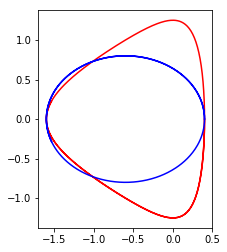

In [9]:
# orbits
dd = 0; nn = 0;
plt.plot(qtraj[:,dd,nn,0], ptraj[:,dd,nn,0],'r')

plt.plot(qtraj[:,0,nn,0], qtraj[:,1,nn,0],'b')

plt.gca().set_aspect('equal', adjustable='box')

In [10]:
from utils import join_q_p

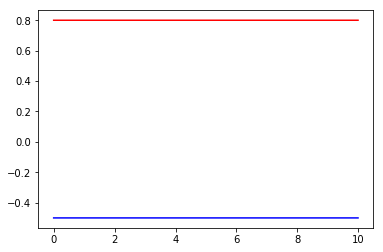

In [11]:
# conserved quantities: angular momentum and energy
J3 = np.multiply(qtraj[:,0,0,0], ptraj[:,1,0,0]) - np.multiply(qtraj[:,1,0,0], ptraj[:,0,0,0])
E = sess.run( settings['hamiltonian']( join_q_p(qtraj,ptraj) ) )
ts = np.arange(0.,10.,.01)
plt.plot(ts, J3,'r')
plt.plot(ts, E,'b')

## Define the model and loss

Define the model as sequence of a symplectic transformation T 

In [6]:
# To account for periodicity start with oscillator flow
stack = [OscillatorFlow()] 
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ZeroCenter(),
                  LinearSymplectic(),
#                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))])
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
T = Chain(stack)

In [7]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

z = make_data(settings, sess)

#loss = make_loss(settings, T, z)
from utils import extract_q_p
with tf.name_scope("canonical_transformation"):
    x = T(z)
    if settings['visualize']:
        q,p = extract_q_p(x)
        tf.summary.histogram("q", q)
        tf.summary.histogram("p", p)
    K = settings['hamiltonian'](x)
    if settings['visualize']:
        tf.summary.histogram('K-Hamiltonian', K)
    # Goldstein eq 10.155: K=-k**2/2. / I3**2
    _,I = extract_q_p(z)
    assert(settings['d'] == 3)
    I3 = I[:,2,:,:]
    expectedK = - settings['k']**2/2. / tf.square(I3)
    loss = tf.reduce_mean(tf.square(K - expectedK))
    tf.summary.scalar('loss', loss)
    
train_op = make_train_op(settings, loss, step)

Instructions for updating:
Colocations handled automatically by placer.
In DiracDistribution constructor: actions =  [[[[0.5488135 ]]

  [[0.71518934]]

  [[0.60276335]]]]
Instructions for updating:
Use tf.cast instead.


## Train

In [8]:
sess.run(tf.global_variables_initializer())

In [9]:
expectedK_np = sess.run(expectedK)
print(expectedK_np)

[[[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]]

 [[-1.3761834]

In [9]:
losses = []

In [10]:
for i in range(int(settings['train_iters'])):
    _, it, loss_np = sess.run([train_op, step, loss])
    if it % 1000 == 0:
        print(it, loss_np)
    losses.append(loss_np)

1000 1.145326
2000 0.89324665
3000 0.7825684
4000 0.75016135
5000 0.7199509
6000 0.6873784
7000 0.66650486
8000 0.6456932
9000 0.63203776
10000 0.61429965
11000 0.7317724


KeyboardInterrupt: 

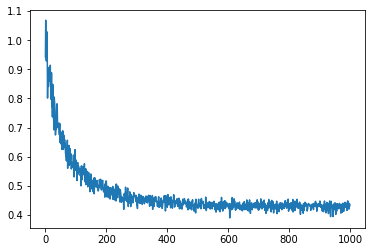

In [10]:
plt.plot(losses[:])

In [28]:
# Set the ZeroCenter bijectors to training mode:
T.set_is_training(True)

In [8]:
tf.contrib.training.train(train_op, logdir=settings['log_dir'], 
                          save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/log/im_tests/kepler/model.ckpt.
INFO:tensorflow:global_step/sec: 43.2564
INFO:tensorflow:global_step/sec: 79.5191
INFO:tensorflow:global_step/sec: 75.1885
INFO:tensorflow:global_step/sec: 78.2098
INFO:tensorflow:global_step/sec: 75.2053
INFO:tensorflow:global_step/sec: 72.5388
INFO:tensorflow:global_step/sec: 67.0089
INFO:tensorflow:global_step/sec: 102.248
INFO:tensorflow:global_step/sec: 94.8274
INFO:tensorflow:global_step/sec: 96.9508
INFO:tensorflow:global_step/sec: 84.8574
INFO:tensorflow:global_step/sec: 96.7633
INFO:tensorflow:global_step/sec: 107.275
INFO:tensorflow:global_step/sec: 98.5955
INFO:tensorflow:global_step/sec: 84.7182
INFO:tensorflow:global_step/sec: 116.681
INFO:tensorflow:global_step/sec: 106.111
INFO:tensorflow:global_step/sec: 108.91
INFO:tensorflow:

KeyboardInterrupt: 

## Test

In [9]:
# Load the latest parameters
saver = tf.train.Saver()
ckpt_state = tf.train.get_checkpoint_state(settings['log_dir'])
saver.restore(sess, ckpt_state.model_checkpoint_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/kepler/model.ckpt-129398


In [11]:
# Set the ZeroCenter bijectors to prediction mode:
T.set_is_training(False)

In [12]:
# Test accuracy on new minibatch
print("Test error: ", sess.run(loss))

Test error:  1.0980934


In [13]:
zz = tf.expand_dims(z[0,:,:,:],0)
x = zz
for i, bijector in enumerate(T.bijectors):        
    print(i, is_symplectic( bijector, x, sess=sess, rtol=1e-06, atol=1e-06))
    x = bijector(x)
print("Full flow:")
is_symplectic( T, zz, sess=sess, rtol=1e-06, atol=1e-06 )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
Full flow:


True

### Visualize after training

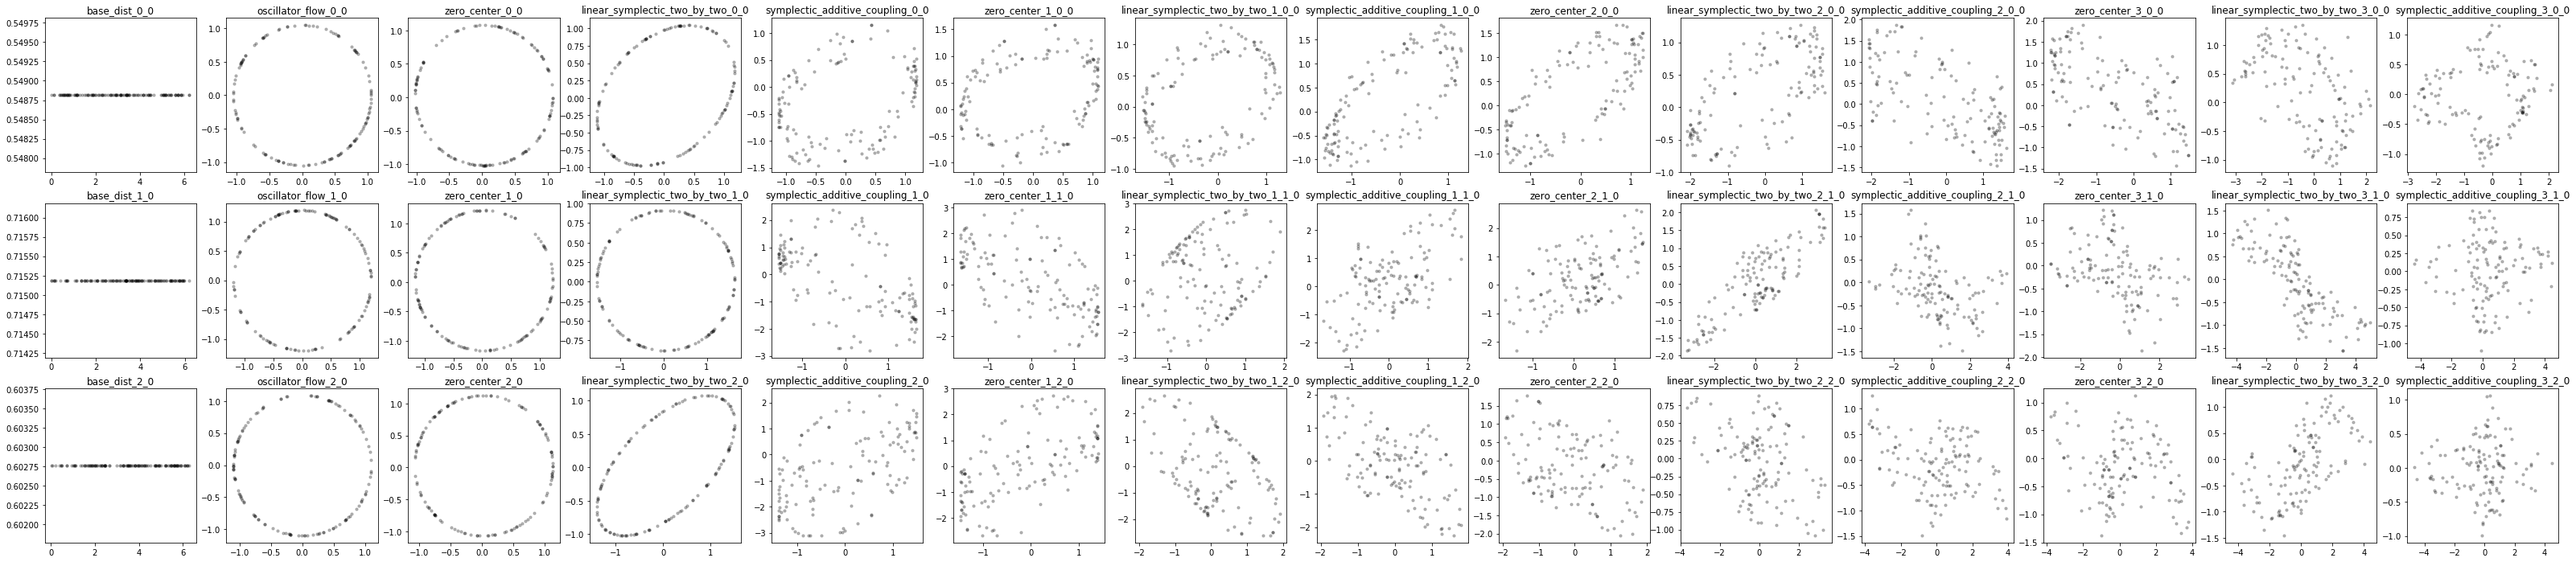

In [14]:
visualize_chain_bijector(T, z, sess=sess)

## Look at the Learned Representation

Try directly integrating the eom of the transformed Hamiltonian

In [15]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(lambda z : settings['hamiltonian'](T(z)),
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition (scale it back so that the motion is in the sampled region)
z0 = sess.run( tf.expand_dims(z[0,:,:,:],0) )
print(z0)

[[[[1.1598992  0.5488135 ]]

  [[5.1529884  0.71518934]]

  [[5.4880705  0.60276335]]]]


In [16]:
traj = sess.run( integrator(z0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
phi_traj, I_traj = extract_q_p( traj )

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Visualize: the transformed trajectories

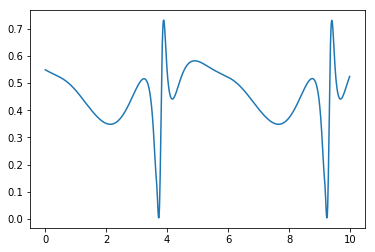

In [17]:
ts = np.arange(0.,10.,.01)

plt.plot(ts, I_traj[:,0,0,0])

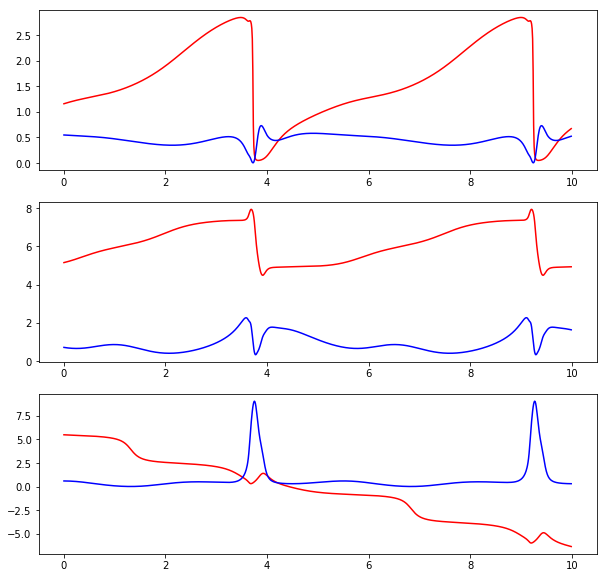

In [18]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts[:], phi_traj[:,d,n,0],'r')
        plt.plot(ts[:], I_traj[:,d,n,0],'b')
        #plt.gca().set_aspect('equal', adjustable='box')

Almost there...

Trajectories of original Hamiltonian

In [19]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# Map to original phase space the initial point
x0 = sess.run( T(tf.expand_dims(z[1,:,:,:],0)) )
print(x0)

[[[[-1.9913255   0.15051866]]

  [[ 0.9272548  -0.33740455]]

  [[-0.22644511 -0.26509267]]]]


In [20]:
print("q0: ", x0[:,:,:,0])
print("p0: ", x0[:,:,:,1])
print("E: ", sess.run( settings['hamiltonian'](x0) ))

q0:  [[[-1.9913255 ]
  [ 0.9272548 ]
  [-0.22644511]]]
p0:  [[[ 0.15051866]
  [-0.33740455]
  [-0.26509267]]]
E:  -0.3494568


In [21]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

visualize the trajectories

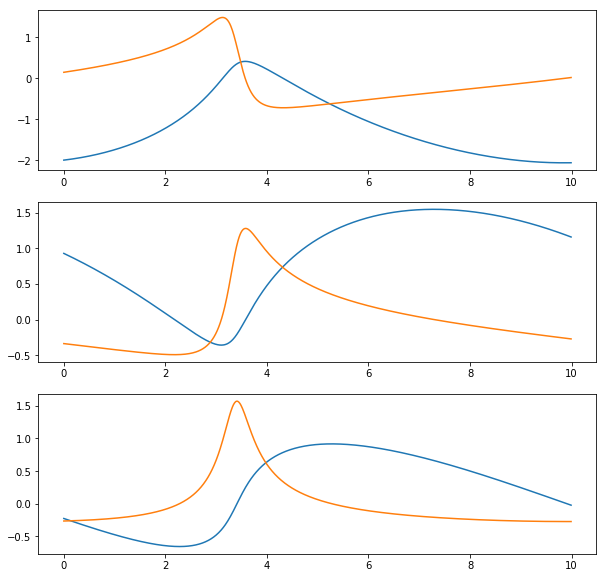

In [22]:
ts = np.arange(0.,10.,.01)

plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, qtraj[:,d,n,0])
        plt.plot(ts, ptraj[:,d,n,0])

map back to action angle

In [23]:
ind_to_stop = 1
trans_traj = sess.run(T.inverse(tf.constant(traj), stop_at=ind_to_stop)) 
phi_trans_traj,I_trans_traj = extract_q_p(trans_traj)
if ind_to_stop == 0:
    osc_traj = T.bijectors[0](tf.constant(trans_traj))
else:
    osc_traj = tf.constant( trans_traj )
q_osc_traj,p_osc_traj = sess.run(extract_q_p(osc_traj))

In [24]:
dd = 0; nn = 0

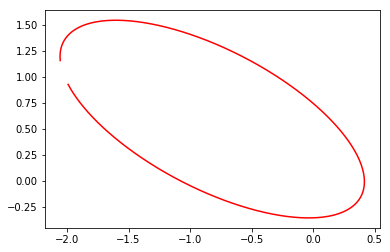

In [25]:
plt.plot(qtraj[:,0,nn,0], qtraj[:,1,nn,0],'r')

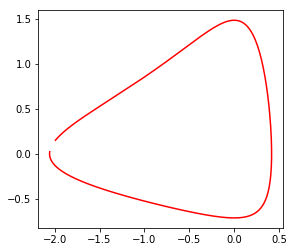

In [26]:
plt.plot(qtraj[:,dd,nn,0], ptraj[:,dd,nn,0],'r')
plt.gca().set_aspect('equal', adjustable='box')

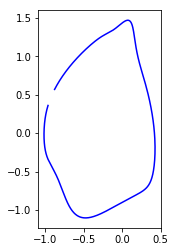

In [27]:
plt.plot(q_osc_traj[:,dd,nn,0], p_osc_traj[:,dd,nn,0],'b')
plt.gca().set_aspect('equal', adjustable='box')

## Conclusions

For the radii minimization loss, the model learns to set $K$ to zero within the region of sampling. This is in general not possible with a symplectic transformation - think about the case of oscillators and trying to set the Hamiltonian in the action-angle variables to zero. In fact it is possible with a time dependent canonical transformation like in Hamilton-Jacobi eq, where Hamilton principal function is its generating function (see Goldstein) but we will not consider it here.

Instead the transformation to $K=F_1$ makes sense and occurs when one solves time-independent Hamiltonian from the reduced Hamilton-Jacobi equation, and Hamilton characteristic function is its generating function (see Goldstein)

TODO: update below

Transformed trajectories

In [95]:
trans_traj = sess.run(T.inverse(traj))
qtraj, ptraj = extract_q_p(trans_traj)

Visualize: the transformed trajectories should be circles so that their radius is a constant of the motion

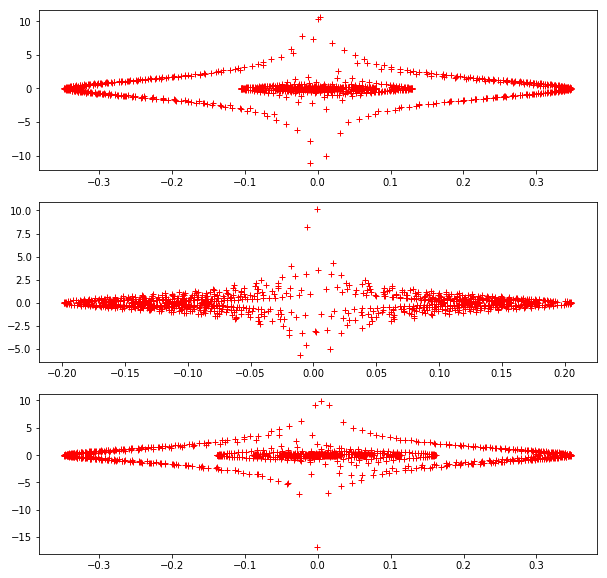

In [96]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        plt.plot(xtraj[:,d,n,0], ytraj[:,d,n,0],'r+')
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        #plt.xlim(-10, 10)
        #plt.ylim(-10, 10)
        #plt.plot(ts, xtraj[:,d,n,0])
        #plt.plot(ts, ytraj[:,d,n,0])
        
#        plt.gca().set_aspect('equal', adjustable='box')